# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [10]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (if any)
df = df.dropna()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


In [11]:
# Create new features
# Binary feature for flights during peak hours (assuming peak hours are 6 AM to 10 PM)
df['is_peak_hour'] = df['flight_hour'].apply(lambda x: 1 if 6 <= x <= 22 else 0)

# Weekend feature 
df['is_weekend'] = df['flight_day'].apply(lambda x: 1 if x in [5, 6] else 0)

# Interaction term for extra baggage and preferred seat
df['extra_baggage_preferred_seat'] = df['wants_extra_baggage'] * df['wants_preferred_seat']

In [12]:
# Identify categorical columns
categorical_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin']

# Use one-hot encoding for categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [13]:
# Define target variable
y = df['booking_complete']

# Define features
X = df.drop(columns=['booking_complete'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Define the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [22]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8535
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.52      0.13      0.21      1480

    accuracy                           0.85     10000
   macro avg       0.69      0.55      0.56     10000
weighted avg       0.81      0.85      0.81     10000



In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Score: ", np.mean(cv_scores))
print("Standard Deviation of CV Score: ", np.std(cv_scores))

Cross-Validation Scores:  [0.84825  0.850125 0.846875 0.844875 0.85675 ]
Mean CV Score:  0.849375
Standard Deviation of CV Score:  0.004067400890003337


Important Features:
purchase_lead               0.146702
flight_hour                 0.113764
length_of_stay              0.110189
flight_day                  0.075886
num_passengers              0.046878
flight_duration             0.035640
booking_origin_Malaysia     0.029079
wants_in_flight_meals       0.021926
is_peak_hour                0.020313
booking_origin_Australia    0.020163
is_weekend                  0.018810
wants_extra_baggage         0.015668
sales_channel_Mobile        0.011825
wants_preferred_seat        0.011151
dtype: float64


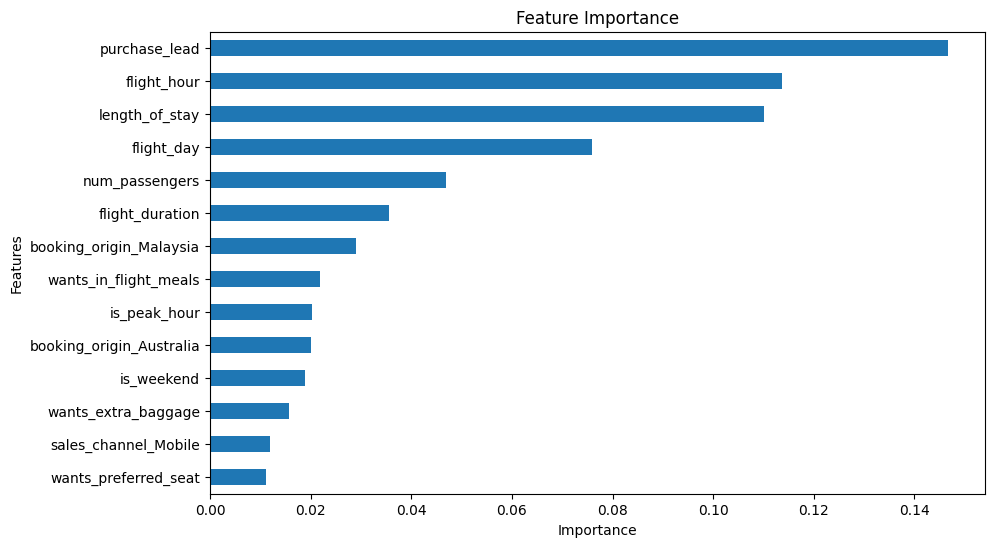

In [32]:
import matplotlib.pyplot as plt

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# Exclude features with very little importance
threshold = 0.01  # Define a threshold for feature importance
important_features = feature_importance_sorted[feature_importance_sorted > threshold]

print("Important Features:")
print(important_features)

# Visualize feature importance
plt.figure(figsize=(10, 6))
important_features.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()